# Book Recommendation System

This uses dataset from kaggle, the dataset includes 3 files
- ratings.csv
- books.csv
- users.csv

Uses pyspark, pandas libraries and prints analytics, graphs, analyses data and generates recommendations for user based on 2 most used techniques apart from the general methods like popularity based recommendation and newest books.

1. Collaborative Filterting method
2. Content-based Filtering method

### Installing required dependencies

In [1]:
!pip3 install pyspark
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Imports required dependencies

In [2]:
import random
import sys
import numpy as np
from numpy import sort
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col, when, lit, split, count, desc, rank, sum

### Pre-load steps
Define dataset paths and check if they exist. If they don't exist the program will exit

In [3]:
booksPath = "dataset/books.csv"
ratingsPath = "dataset/ratings.csv"
usersPath = "dataset/users.csv"

try:
  open(booksPath, "r")
  print("Found books dataset")
except IOError:
  print("Books dataset doesn't exist")
  sys.exit()

try:
  open(ratingsPath, "r")
  print("Found ratings dataset")
except IOError:
  print("Ratings dataset doesn't exist")
  sys.exit()

try:
  open(usersPath, "r")
  print("Found users dataset")
except IOError:
  print("Users dataset doesn't exist!")
  sys.exit()

Found books dataset
Found ratings dataset
Found users dataset


### Initialize Spark Session
As we are using Spark for further processing, initially we need to initiate the spark session

In [4]:
spark = SparkSession.builder.appName('recsys').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/10/15 19:12:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Load ratings dataset
Here we are performing 2 operations
- Declare columns used in all tables for reuse and avoid string caused errors further
- Load ratings.csv through spark
  - drop null values
  - filter out isbn values which are invalid or which has non-numeric characters
  - cast isbn to integer
  - cast userId to integer 


In [5]:
col_rating = "Book-Rating"
col_publisher = "Publisher"
col_yop = "Year-Of-Publication"
col_location = "Location"
col_age = "Age"
col_city = "City"
col_state = "State"
col_country = "Country"
col_isbn = "ISBN"
col_userId = "User-ID"
col_author = "Book-Author"
col_rating = "Book-Rating"
col_country = "Country"
col_title = "Book-Title"

ratingsDataSet = spark.read.csv(ratingsPath, sep=';', inferSchema=True, header=True)

ratingsDataSet = ratingsDataSet.withColumn(col_rating,
                    when(col(col_rating) == 0, 1)
                    .otherwise(col(col_rating))
                  )
ratingsDataSet = ratingsDataSet.dropna()

validRatings = ratingsDataSet[col_isbn].rlike(r'^\d+$')
ratingsDataSet = ratingsDataSet.filter(validRatings)

ratingsDataSet = ratingsDataSet.withColumn(col_isbn, ratingsDataSet[col_isbn].cast("long"))

validUsers = ratingsDataSet[col_userId].rlike(r'^\d+$')
ratingsDataSet = ratingsDataSet.filter(validUsers)
ratingsDataSet = ratingsDataSet.withColumn(col_userId, ratingsDataSet[col_userId].cast("long"))

ratingsDataSet = ratingsDataSet.sort(col_isbn)

print("Ratings Dataset records: ", ratingsDataSet.count())
# ratingsDataSet.show(20, truncate=True)

# print("in descending order")
last = ratingsDataSet.sort(ratingsDataSet[col_isbn].desc())
last.show(20)

# print schema
ratingsDataSet.printSchema()

Ratings Dataset records:  1053232
+-------+-------------+-----------+
|User-ID|         ISBN|Book-Rating|
+-------+-------------+-----------+
|  95672|9999999999999|          5|
| 212054|9999000350738|          1|
| 182381|9978055329597|          5|
|  35480|9903499424126|         10|
| 189312|9803810507210|          1|
|  71361|9789895550524|          5|
|  88099|9789875503373|          9|
| 156876|9789875503373|          1|
| 193565|9789875503373|          1|
|  41912|9789727480340|          5|
| 197529|9789727480340|          7|
| 161099|9789727114627|          1|
| 197529|9789727114627|          1|
| 164581|9789727114627|          7|
| 153091|9789727114627|          1|
| 133431|9789725752418|          1|
| 251602|9789725752418|          1|
| 197529|9789725300565|          5|
| 129633|9789724129457|          5|
| 120934|9789724120607|          8|
+-------+-------------+-----------+
only showing top 20 rows

root
 |-- User-ID: long (nullable = true)
 |-- ISBN: long (nullable = true)


### Load books dataset
- Load books.csv using spark
- drop columns that are not required (image-urls)
- drop null values
- filter valid isbn's
- cast isbn to integers

In [6]:
booksDataSet = spark.read.csv(booksPath, sep=';', inferSchema=True, header=True)
booksDataSet = booksDataSet.drop('Image-URL-S', 'Image-URL-M', 'Image-URL-L')
booksDataSet = booksDataSet.withColumn(col_yop, 
                              when(col(col_yop) == 0, 1999)
                                .otherwise(col(col_yop))
                            )

booksDataSet = booksDataSet.dropna()

validBooks = booksDataSet[col_isbn].rlike(r'^\d+$')
booksDataSet = booksDataSet.filter(validBooks)

booksDataSet = booksDataSet.withColumn(col_isbn, booksDataSet[col_isbn].cast("long"))
booksDataSet = booksDataSet.sort(col_isbn)

print("Book Dataset records: ", booksDataSet.count())
booksDataSet.show(20)

last = booksDataSet.sort(booksDataSet[col_isbn].desc())
last.show(20)

booksDataSet.printSchema()

Book Dataset records:  249040
+-------+--------------------+--------------------+-------------------+--------------------+
|   ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|
+-------+--------------------+--------------------+-------------------+--------------------+
| 913154|The Way Things Wo...|C. van Amerongen ...|               1967|Simon &amp; Schuster|
|1010565|     Mog's Christmas|         Judith Kerr|               1992|             Collins|
|1046438|                Liar|         Stephen Fry|               1999|    Harpercollins Uk|
|1046713|Twopence to Cross...|     Helen Forrester|               1992|HarperCollins Pub...|
|1046934|The Prime of Miss...|        Muriel Spark|               1999|Trafalgar Square ...|
|1047213|    The Fighting Man|      Gerald Seymour|               1993|HarperCollins Pub...|
|1047647|  First Among Equals|      Jeffrey Archer|               2000|Trafalgar Square ...|
|1047663|    Matter Of Honour|      Jeff

### Load users data
- Load users.csv using spark
- for rows having age as null, replacing with 23 as default
- split location into city, state, country
- filter with valid userIds
- cast userIds to long
- drop null values

In [7]:
usersDataSet = spark.read.csv(usersPath, sep=';', inferSchema=True, header=True)

# set default age to 23 for NULL values
usersDataSet = usersDataSet.withColumn(col_age, 
                              when(col(col_age) == "NULL", 23)
                                .otherwise(col(col_age))
                            )

usersDataSet = usersDataSet.withColumn(col_city, split(col(col_location), ", ")[0]) \
       .withColumn(col_state, split(col(col_location), ", ")[1]) \
       .withColumn(col_country, split(col(col_location), ", ")[2])

usersDataSet = usersDataSet.dropna()

validUsers = usersDataSet[col_userId].rlike(r'^\d+$')
usersDataSet = usersDataSet.filter(validUsers)
usersDataSet = usersDataSet.withColumn(col_userId, usersDataSet[col_userId].cast("long"))

print("User Dataset records: ", usersDataSet.count())
usersDataSet.show(20)
usersDataSet.printSchema()

User Dataset records:  274280
+-------+--------------------+---+--------------+---------------+--------------+
|User-ID|            Location|Age|          City|          State|       Country|
+-------+--------------------+---+--------------+---------------+--------------+
|      1|  nyc, new york, usa| 23|           nyc|       new york|           usa|
|      2|stockton, califor...| 18|      stockton|     california|           usa|
|      3|moscow, yukon ter...| 23|        moscow|yukon territory|        russia|
|      4|porto, v.n.gaia, ...| 17|         porto|       v.n.gaia|      portugal|
|      5|farnborough, hant...| 23|   farnborough|          hants|united kingdom|
|      6|santa monica, cal...| 61|  santa monica|     california|           usa|
|      7| washington, dc, usa| 23|    washington|             dc|           usa|
|      8|timmins, ontario,...| 23|       timmins|        ontario|        canada|
|      9|germantown, tenne...| 23|    germantown|      tennessee|           usa

### Merging the datasets
- first join ratings with books on isbn
- then join the result with users on userId

In [8]:
# Join the Ratings, Books, and Users DataFrames
dataset = ratingsDataSet.join(other=booksDataSet, on=col_isbn, how='inner')
dataset = dataset.join(other=usersDataSet, on=col_userId, how='inner')

# Print the merged DataFrame
print("Dataset records after merge: ", dataset.count())
dataset.show(20)

Dataset records after merge:  923960


+-------+----------+-----------+--------------------+--------------------+-------------------+--------------------+--------------------+---+---------------+----------------+-------+
|User-ID|      ISBN|Book-Rating|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|            Location|Age|           City|           State|Country|
+-------+----------+-----------+--------------------+--------------------+-------------------+--------------------+--------------------+---+---------------+----------------+-------+
|     22|3404921038|          7|Wie Barney es sieht.|    Mordecai Richler|               2002|             L�?¼bbe|erfurt, thueringe...| 23|         erfurt|      thueringen|germany|
|     22|3442353866|          1|Der Fluch der Kai...|      Eleanor Cooney|               2001|            Goldmann|erfurt, thueringe...| 23|         erfurt|      thueringen|germany|
|     22|3442410665|          1|   Sturmzeit. Roman.|      Charlotte Link|               1

### Representation of books published in each year as a bar graph

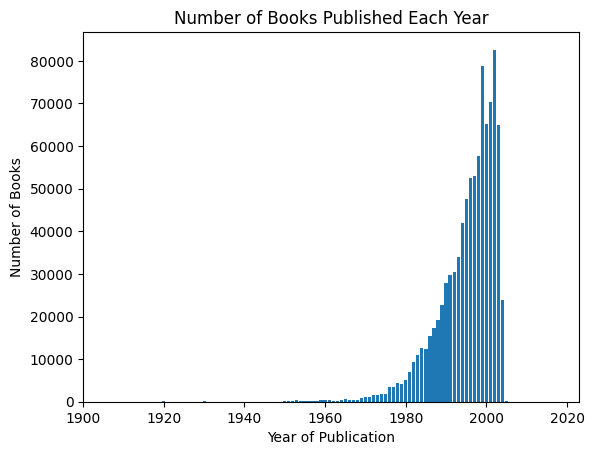

In [9]:
book_counts_by_year = dataset.groupBy(col_yop).count().orderBy(col_yop)
book_counts_by_year_pd = book_counts_by_year.toPandas()

plt.bar(book_counts_by_year_pd[col_yop], book_counts_by_year_pd["count"])
plt.xlabel("Year of Publication")
plt.xlim(left=1900, right=2023)
plt.ylabel("Number of Books")
plt.title("Number of Books Published Each Year")
plt.show()

### Prints Number of books written by each Author as bar graph

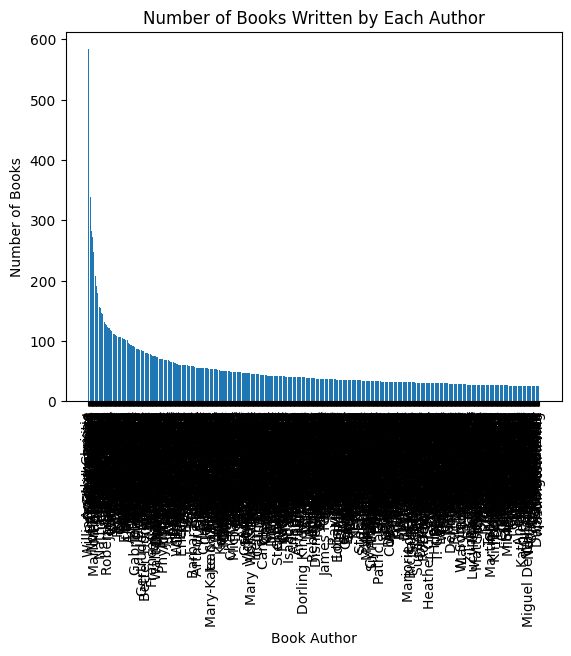

In [10]:
booksDataSet.createOrReplaceTempView("books_by_author")

books_by_author = spark.sql("SELECT `Book-Author`, COUNT(`ISBN`) AS `num_books` FROM books_by_author GROUP BY `Book-Author` ORDER BY `num_books` DESC LIMIT 1000")

books_by_author_pd = books_by_author.toPandas()

plt.bar(books_by_author_pd[col_author], books_by_author_pd["num_books"])
plt.xticks(rotation=90)
plt.xlabel("Book Author")
plt.ylabel("Number of Books")
plt.title("Number of Books Written by Each Author")
plt.show()

### Graph representation of Number of Books vs Authors vs Publishers vs Cities vs Readers

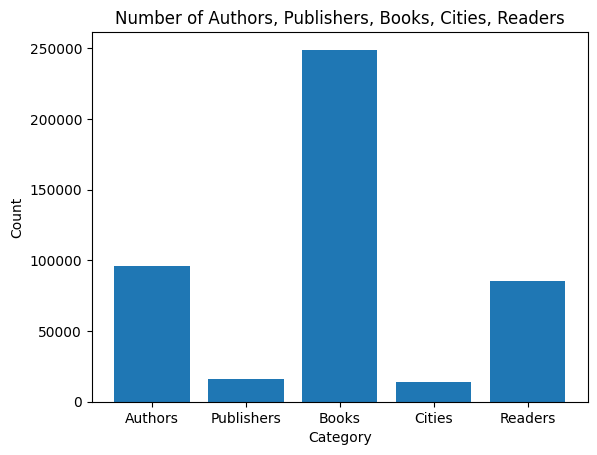

In [11]:
num_authors = booksDataSet.select(col_author).distinct().count()
num_publishers = booksDataSet.select(col_publisher).distinct().count()
num_books = booksDataSet.select(col_isbn).distinct().count()
num_countries = dataset.select(col_city).distinct().count()
num_users = dataset.select(col_userId).distinct().count()

counts = [num_authors, num_publishers, num_books, num_countries, num_users]
labels = ['Authors', 'Publishers', 'Books', 'Cities', 'Readers']

plt.bar(labels, counts)
plt.title('Number of Authors, Publishers, Books, Cities, Readers')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

### Top 20 authors by number of books written
- Number of books on y-axis
- Author name on x-axis

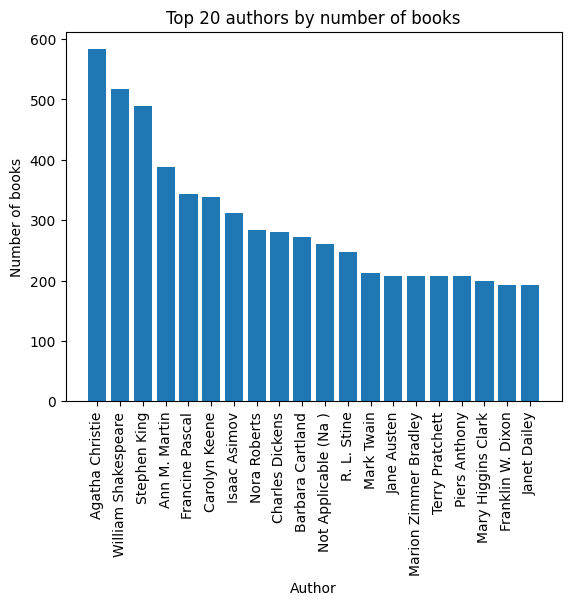

In [12]:
books_by_author = booksDataSet.groupBy(col_author).count()

top_authors = books_by_author.orderBy(desc("count")).limit(20)

plt.bar(
  top_authors.select(col_author).rdd.flatMap(lambda x: x).collect(), 
  top_authors.select("count").rdd.flatMap(lambda x: x).collect()
)
plt.xlabel("Author")
plt.xticks(rotation=90)
plt.ylabel("Number of books")
plt.title("Top 20 authors by number of books")
plt.show()

### Top 20 book publishers vs percent of books published

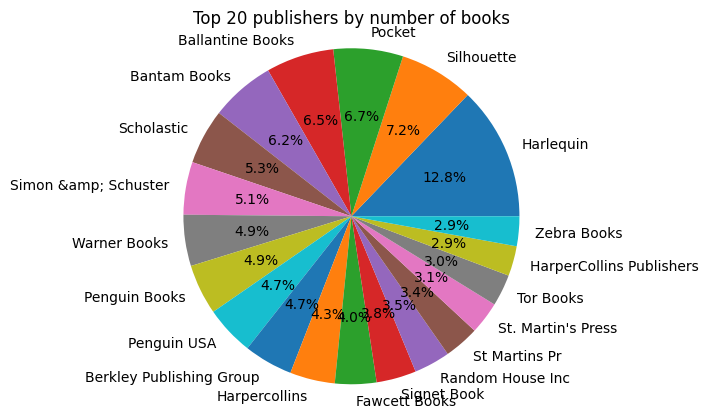

In [13]:
books_by_publisher = booksDataSet.groupBy(col_publisher).count()

top_publishers = books_by_publisher.orderBy(desc("count")).limit(20)

plt.pie(
    top_publishers
      .select("count")
      .rdd.flatMap(lambda x: x).collect(), 
    labels=top_publishers
      .select(col_publisher)
      .rdd.flatMap(lambda x: x).collect(), 
    autopct="%1.1f%%"
)
plt.axis("equal")
plt.title("Top 20 publishers by number of books")
plt.show()

### Top 100 book publishers vs percent of books published

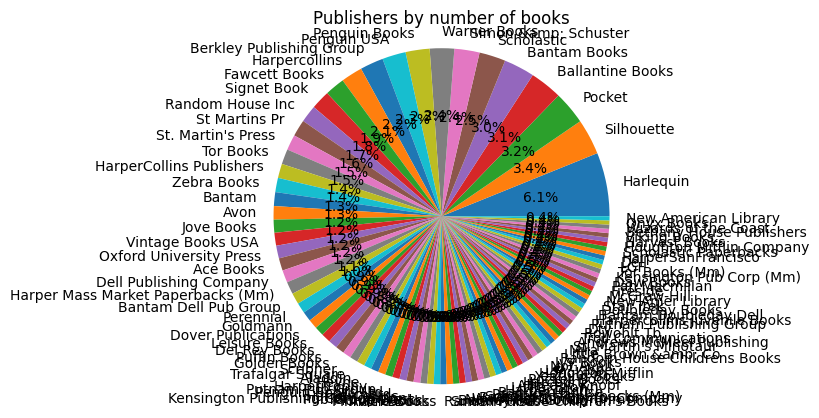

In [14]:
top_100_publishers = books_by_publisher.orderBy(desc("count")).limit(100)

plt.pie(
    top_100_publishers
      .select("count")
      .rdd.flatMap(lambda x: x).collect(), 
    labels=top_100_publishers
      .select(col_publisher)
      .rdd.flatMap(lambda x: x).collect(), 
    autopct="%1.1f%%"
)
plt.axis("equal")
plt.title("Publishers by number of books")
plt.show()

### Graphical representation of number of books vs average ratings

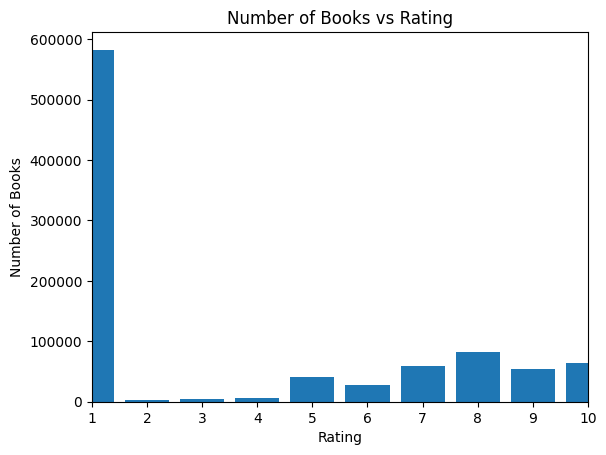

In [15]:
rating_counts = dataset.groupBy(col_rating).count().sort(col_rating)

ratings_df_pd = rating_counts.toPandas()

plt.bar(ratings_df_pd[col_rating], ratings_df_pd["count"])
plt.title("Number of Books vs Rating")
plt.xlabel("Rating")
plt.xlim(1,10)
plt.ylabel("Number of Books")
plt.show()

### Top 10 books in each country as Graph
Note: There are invalid countries too, which takes a lot of time to print so printing 10 random countries 

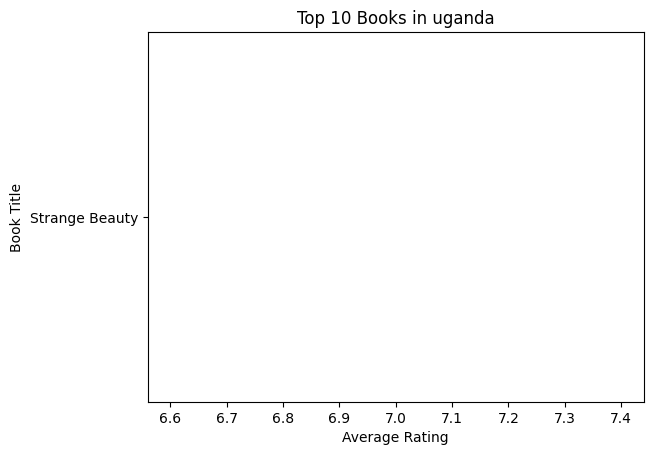

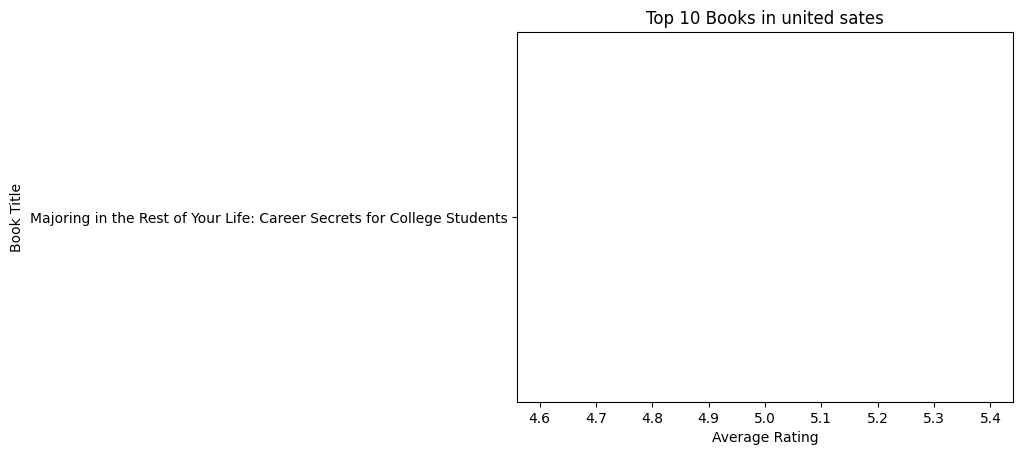

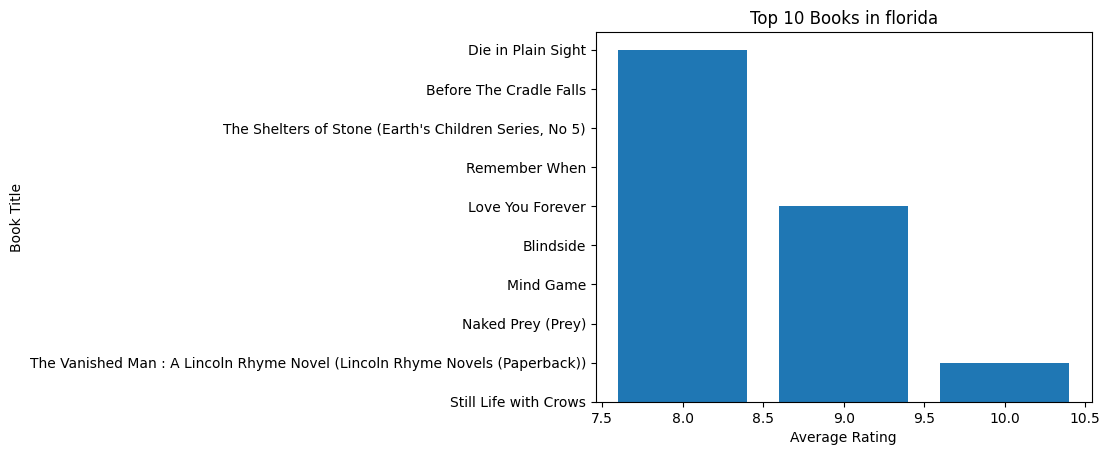

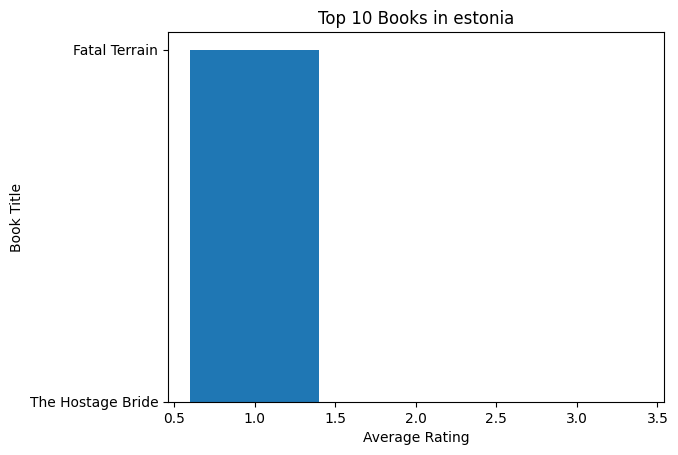

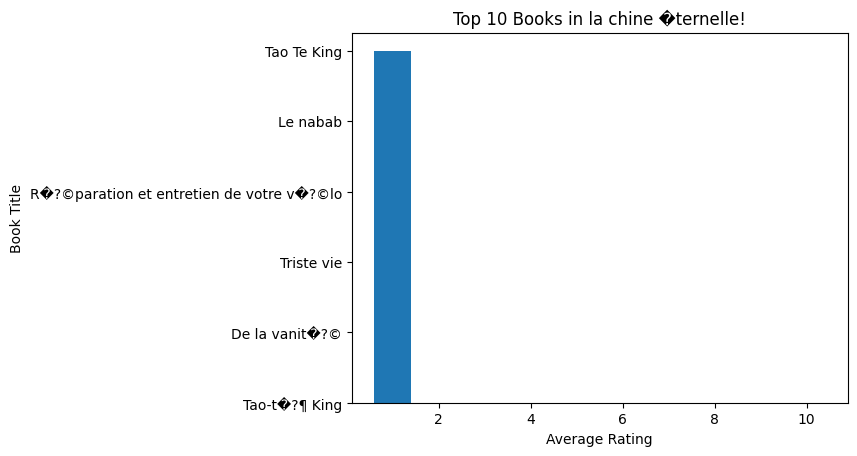

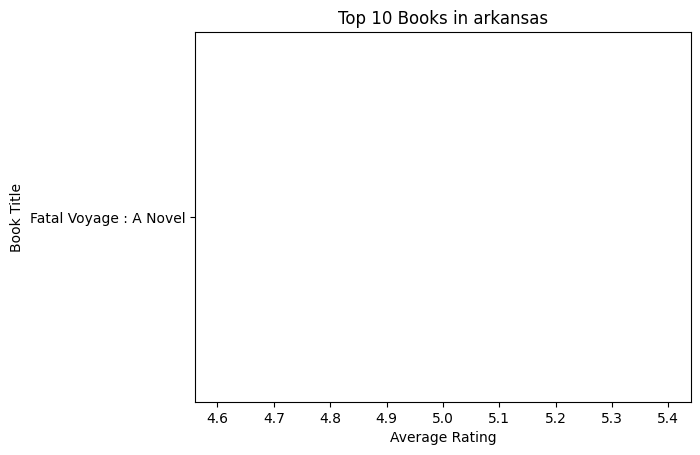

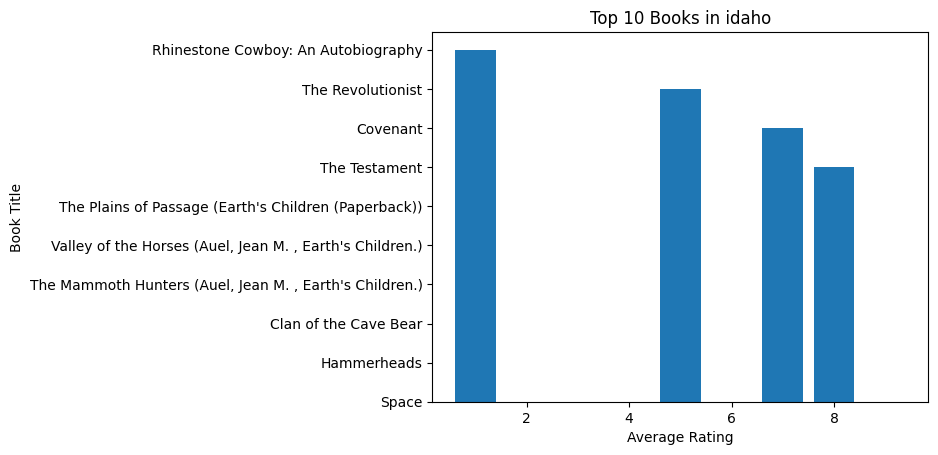

In [16]:
countries = [row[col_country] for row in usersDataSet.select(col_country).distinct().collect()]

few_countries = random.sample(countries, 10)

for country in few_countries:
  filtered_df = dataset.filter(dataset[col_country] == country)
  avg_ratings = filtered_df.groupBy(col_title).agg({col_rating: "avg"})

  top_books = avg_ratings.orderBy(desc("avg(Book-Rating)")).limit(10)
  if top_books.count() > 0:
    top_books_pd = top_books.toPandas()
    plt.bar(top_books_pd["avg(Book-Rating)"], top_books_pd[col_title])
    plt.ylabel("Book Title")
    plt.xlabel("Average Rating")
    plt.title(f"Top 10 Books in {country}")
    plt.show()

# Popular books by Total Rating
This will calculate sum of all ratings given to all books.

In [17]:
groupedByIsbn = dataset.groupBy(col_isbn)\
               .agg({col_rating: 'sum'})\
               .withColumnRenamed('sum(Book-Rating)', 'total_rating')

leftJoinedDf = dataset.join(groupedByIsbn, col_isbn, 'left')

leftJoinedDf = leftJoinedDf.dropDuplicates([col_isbn])

popular_books = leftJoinedDf.select(col_isbn, col_title, col_author, 'total_rating')\
                        .sort(col('total_rating').desc())

less_popular_books = leftJoinedDf.select(col_isbn, col_title, col_author, 'total_rating')\
                        .sort(col('total_rating').asc())

def show_less_popular_books(n):
  less_popular_books.show(n)

def most_popular_books(n):
  popular_books.show(n)

In [18]:
most_popular_books(100)

show_less_popular_books(100)

+----------+--------------------+--------------------+------------+
|      ISBN|          Book-Title|         Book-Author|total_rating|
+----------+--------------------+--------------------+------------+
| 316666343|The Lovely Bones:...|        Alice Sebold|        6021|
| 971880107|         Wild Animus|        Rich Shapero|        4430|
| 385504209|   The Da Vinci Code|           Dan Brown|        4426|
| 312195516|The Red Tent (Bes...|       Anita Diamant|        3336|
|  60928336|Divine Secrets of...|       Rebecca Wells|        2875|
| 142001740|The Secret Life o...|       Sue Monk Kidd|        2846|
| 446672211|Where the Heart I...|        Billie Letts|        2543|
| 671027360| Angels &amp; Demons|           Dan Brown|        2455|
| 452282152|Girl with a Pearl...|     Tracy Chevalier|        2367|
| 316601950|The Pilot's Wife ...|        Anita Shreve|        2206|
| 786868716|The Five People Y...|         Mitch Albom|        2092|
| 743418174|         Good in Bed|     Jennifer W

+--------+--------------------+--------------------+------------+
|    ISBN|          Book-Title|         Book-Author|total_rating|
+--------+--------------------+--------------------+------------+
|23485116|Explorations in B...|Stanley E. Gunstream|           1|
|60002182|Amazing Grace : T...|        Steve Turner|           1|
|23658207|  Asian Philosophies|      John M. Koller|           1|
| 2156083|Of This and Other...|         C. S. Lewis|           1|
|23888873|American Governme...|      Karen O'Connor|           1|
| 2157411|King Edward VIII:...|      Philip Ziegler|           1|
|24031216|Freedom to Learn ...|      Carl R. Rogers|           1|
| 2212080|The eagle has landed|        Jack Higgins|           1|
|25002430|ART THE ARTS &amp...|   Mortimer J. Adler|           1|
| 2231441|     Family business|        Anna Murdoch|           1|
|25174215|   The AMERICAN WEST|           Dee Brown|           1|
| 2238861|    To Play the King|       Michael Dobbs|           1|
|25446002|

# Popular books by Average Rating
This will calculate average sum of all ratings given to all books.

In [19]:
groupedByIsbnAvg = dataset.groupBy(col_isbn)\
               .agg({col_rating: 'avg'})\
               .withColumnRenamed('avg(Book-Rating)', 'avg_rating')

leftJoinedDfAvg = dataset.join(groupedByIsbnAvg, col_isbn, 'left')

leftJoinedDfAvg = leftJoinedDfAvg.dropDuplicates([col_isbn])
popular_books_avg = leftJoinedDfAvg.select(col_isbn, col_title, col_author, 'avg_rating')\
                        .sort(col('avg_rating').desc())

less_popular_books_avg = leftJoinedDfAvg.select(col_isbn, col_title, col_author, 'avg_rating')\
                        .sort(col('avg_rating').asc())

def less_popular_books_by_avg(n):
  less_popular_books_avg.show(n)

def most_popular_books_avg(n):
  popular_books_avg.show(n)

In [20]:
most_popular_books_avg(100)

less_popular_books_by_avg(100)

+---------+--------------------+--------------------+----------+
|     ISBN|          Book-Title|         Book-Author|avg_rating|
+---------+--------------------+--------------------+----------+
|130811270|Archaeological Re...|  Peter N. Peregrine|      10.0|
|312170092|Shallow Grave in ...|       Harry Farrell|      10.0|
|133036030|Brain Builders!: ...|     Richard Leviton|      10.0|
|130464171|Matthew Arnold: a...|     David J DeLaura|      10.0|
|133502813|           Chemistry|        John McMurry|      10.0|
|  4133439|Light in Watercol...|         John Lidzey|      10.0|
|133734579|Anthology of Amer...|    George McMichael|      10.0|
|  6492126|A Day in the Life...|  Collins Publishers|      10.0|
|135113385|The Joy Within: A...|      Joan Goldstein|      10.0|
|  7113668|Near Eastern Fell...|       Mark Richards|      10.0|
|140071776|    King Lear -Op/46| William Shakespeare|      10.0|
| 20429819|The Macmillan Ill...|        Dougal Dixon|      10.0|
|140118047|Blindfold Hors

+--------+--------------------+--------------------+----------+
|    ISBN|          Book-Title|         Book-Author|avg_rating|
+--------+--------------------+--------------------+----------+
| 6614000|Walt and Pepper (...|           Lisl Weil|       1.0|
| 6728537|The Warriors of Taan|     Louise Lawrence|       1.0|
|26892677|Frogs Only! (Mupp...|        Louise Gikow|       1.0|
| 6728774|       Bury the Dead|        Peter Carter|       1.0|
| 1842749|  The Growing Summer|    Noel Streatfeild|       1.0|
| 6743773|Vlad the Drac Goe...|         Ann Jungman|       1.0|
| 1382608|         On the Road|         Huck Scarry|       1.0|
| 1952404|       Friend Monkey|        P. L Travers|       1.0|
| 2179687|Christmas in Amer...|         David Cohen|       1.0|
| 2160595|C. S. Lewis: A bi...|Roger Lancelyn Green|       1.0|
| 2234491|          Wall games|       Michael Dobbs|       1.0|
| 6923119|The Clue of the V...|       Carolyn Keene|       1.0|
|26035200|  New Orleans Legacy|    Alexa

# Popular books by Author
This will filter books by Author name

In [21]:
def most_popular_books_avg_by_author(author, n):
  popular_books_avg.filter(col(col_author) == author).show(n)

In [22]:
most_popular_books_avg_by_author("Alice Sebold", 10)

most_popular_books_avg_by_author("Marie Goodwin", 3)

most_popular_books_avg_by_author("J. K. Rowling", 15)

+----------+--------------------+------------+------------------+
|      ISBN|          Book-Title| Book-Author|        avg_rating|
+----------+--------------------+------------+------------------+
|1402521154|    The Lovely Bones|Alice Sebold|               5.0|
| 316666343|The Lovely Bones:...|Alice Sebold| 4.899104963384866|
| 743529782|               Lucky|Alice Sebold|               4.5|
| 316168815|    The Lovely Bones|Alice Sebold| 4.280898876404494|
| 684857820|               Lucky|Alice Sebold| 4.177215189873418|
| 316096199|    Lucky : A Memoir|Alice Sebold| 4.165517241379311|
|9879397274|      Desde Mi Cielo|Alice Sebold|2.6666666666666665|
|3442545528|   In meinem Himmel.|Alice Sebold|               1.0|
| 965542734|               Lucky|Alice Sebold|               1.0|
|1586638661|The Lovely Bones ...|Alice Sebold|               1.0|
+----------+--------------------+------------+------------------+
only showing top 10 rows



+--------+--------------------+-------------+----------+
|    ISBN|          Book-Title|  Book-Author|avg_rating|
+--------+--------------------+-------------+----------+
|27368718|Where the Towers ...|Marie Goodwin|       1.0|
+--------+--------------------+-------------+----------+



+----------+--------------------+-------------+-----------------+
|      ISBN|          Book-Title|  Book-Author|       avg_rating|
+----------+--------------------+-------------+-----------------+
|8478886567|Harry Potter y la...|J. K. Rowling|             10.0|
| 613496744|Harry Potter and ...|J. K. Rowling|             10.0|
| 439321603|Fantastic Beasts ...|J. K. Rowling|             10.0|
| 439321611|Fantastic Beasts ...|J. K. Rowling|             10.0|
| 439567629|Harry Potter and ...|J. K. Rowling|             10.0|
| 786222727|Harry Potter and ...|J. K. Rowling|             10.0|
| 439554896|Harry Potter and ...|J. K. Rowling|9.333333333333334|
| 747545774|Harry Potter and ...|J. K. Rowling|              9.0|
|1582348278|Harri Potter maen...|J. K. Rowling|              9.0|
| 439294827|Harry Potter and ...|J. K. Rowling|              9.0|
|8478886141|Harry Potter Y LA...|J. K. Rowling|              9.0|
|3551553076|Quidditch Im Wand...|J. K. Rowling|              8.0|
|158130657

# Using Collaborative Filtering method
- In this method, we are finding the books that were rated by given user-id
- We collect the isbn ids of the books in above step and collect ids of users who also rated the books that were rated by given user
- With the collected userIds, we are collecting books to recommend as the books which are not rated by given user but are rated by mutual readers 
- Picking few random books, if the number of books is more than the limit we require
- Finally select titles of the books for which we have the isbn

In [23]:
def get_collab_recommendation_random(user_id, num_books=5):
    books_rated_by_user = ratingsDataSet.select(col_isbn)\
                            .where(col(col_userId) == user_id)\
                            .rdd.map(lambda r: r[0]).collect()
    users_rated_same_books = ratingsDataSet.select(col_userId)\
                                .where(col(col_isbn).isin(books_rated_by_user) & (col(col_userId) != user_id))\
                                    .distinct().rdd.map(lambda r: r[0]).collect()

    books_rated_by_users = ratingsDataSet.select(col_isbn)\
                            .where(col(col_userId).isin(users_rated_same_books))\
                                .distinct().rdd.map(lambda r: r[0]).collect()
    books_to_recommend = [book for book in books_rated_by_users if book not in books_rated_by_user]

    if len(books_to_recommend) > num_books:
        books_to_recommend = random.sample(books_to_recommend, num_books)
        
    books = booksDataSet.select(col_title, col_isbn, col_author, col_yop, col_publisher)\
                                .where(col(col_isbn).isin(books_to_recommend)).toPandas()

    return books

In [24]:
print(get_collab_recommendation_random(276747).to_string())

                                                         Book-Title        ISBN           Book-Author  Year-Of-Publication           Publisher
0                                                          Timbuktu   312975287           Paul Auster                 2000  St. Martin's Press
1  Delilah Doolittle and the Canine Chorus: A Pet Detective Mystery   425178013       Patricia Guiver                 2001         Prime Crime
2                    Something More: Excavating Your Authentic Self   446677086  Sarah Ban Breathnach                 2000        Warner Books
3                                                Lake in the Clouds   553801406           SARA DONATI                 2002              Bantam
4                                                Black Coffee Blues  1880985055               Rollins                 1992      Pub Group West


# Collaborative filtering method based on book rating
- Here we are doing the similar filter as above method but instead of picking random books, we are calculating the rating of book given by all users and picking the top one's
- Also we are adding few filters such as pull books rated by users in same country, same state or same city

In [25]:
booksAndRatingsDataset = booksDataSet.join(other=ratingsDataSet, on=col_isbn, how='inner')
booksAndRatingsDataset = booksAndRatingsDataset.drop(col_userId)

booksAndRatingsDataset = booksAndRatingsDataset.withColumn(col_rating, booksAndRatingsDataset[col_rating].cast("int"))

totalRatingsDataset = booksAndRatingsDataset.groupBy(col_isbn, col_title, col_author, col_yop, col_publisher)\
                    .agg(sum(col_rating).alias("Total-Rating"))

def get_collab_recommendation_by_rating(user_id, num_books=5, same_country=False, same_state=False, same_city=False):
    books_rated_by_user = ratingsDataSet.select(col_isbn).where(col(col_userId) == user_id).rdd.map(lambda r: r[0]).collect()

    users_rated_same_books = ratingsDataSet.select(col_userId).where(col(col_isbn).isin(books_rated_by_user) & (col(col_userId) != user_id))\
                              .distinct().limit(100).rdd.map(lambda r: r[0]).collect()

    books_rated_by_users = ratingsDataSet.select(col_isbn, col_rating, col_userId).where(col(col_userId).isin(users_rated_same_books))\
                            .distinct()
    
    if same_country :
        country_of_user = usersDataSet.select(col_country).where(col(col_userId) == user_id).limit(1).collect()[0][col_country]
        users_in_same_country = usersDataSet.select(col_userId)\
                                .where(col(col_country) == country_of_user)\
                                .limit(1000)\
                                .rdd.map(lambda r: r[0]).collect()
        books_rated_by_users = books_rated_by_users.select(col_isbn, col_rating, col_userId)\
                                .where(col(col_userId).isin(users_in_same_country))
    elif same_state:
        state_of_user = usersDataSet.select(col_state).where(col(col_userId) == user_id).limit(1).collect()[0][col_state]
        users_in_same_state = usersDataSet.select(col_userId)\
                                .where(col(col_state) == state_of_user)\
                                .limit(1000)\
                                .rdd.map(lambda r: r[0]).collect()
        books_rated_by_users = books_rated_by_users.select(col_isbn, col_rating, col_userId)\
                                .where(col(col_userId).isin(users_in_same_state))
    elif same_city:
        city_of_user = usersDataSet.select(col_city).where(col(col_userId) == user_id).limit(1).collect()[0][col_city]
        users_in_same_city = usersDataSet.select(col_userId)\
                                .where(col(col_city) == city_of_user)\
                                .limit(1000)\
                                .rdd.map(lambda r: r[0]).collect()
        books_rated_by_users = books_rated_by_users.select(col_isbn, col_rating, col_userId)\
                                .where(col(col_userId).isin(users_in_same_city))

    books_rated_by_users = books_rated_by_users.rdd.map(lambda r: r[0]).collect()

    books_to_recommend = [book for book in books_rated_by_users if book not in books_rated_by_user]

    if len(books_to_recommend) > 1000:
        books_to_recommend = books_to_recommend[0:1000]

    books = totalRatingsDataset.select(col_title, col_isbn, "Total-Rating", col_author, col_yop, col_publisher)\
                                .where(col(col_isbn).isin(books_to_recommend))\
                                .sort(col("Total-Rating").desc()).limit(1000).toPandas()
    
    if len(books) > num_books:
        books = books[0:num_books]

    return books

In [26]:
print(get_collab_recommendation_by_rating(276747, same_country=True).to_string())

                                           Book-Title       ISBN  Total-Rating         Book-Author  Year-Of-Publication         Publisher
0                                         Wild Animus  971880107          4474        Rich Shapero                 2004           Too Far
1  Where the Heart Is (Oprah's Book Club (Paperback))  446672211          2692        Billie Letts                 1998      Warner Books
2                                      A Time to Kill  440211727          1862        JOHN GRISHAM                 1992              Dell
3                                       Jurassic Park  345370775          1851    Michael Crichton                 1999  Ballantine Books
4                                      The Bean Trees   60915544          1124  Barbara Kingsolver                 1989         Perennial


In [27]:
print(get_collab_recommendation_by_rating(276747, same_country=False).to_string())

                                        Book-Title       ISBN  Total-Rating      Book-Author  Year-Of-Publication                   Publisher
0  Divine Secrets of the Ya-Ya Sisterhood: A Novel   60928336          2936    Rebecca Wells                 1997                   Perennial
1                              Angels &amp; Demons  671027360          2496        Dan Brown                 2001                 Pocket Star
2                                      Good in Bed  743418174          2133  Jennifer Weiner                 2002     Washington Square Press
3                            To Kill a Mockingbird  446310786          2089       Harper Lee                 1988  Little Brown &amp; Company
4                       Interview with the Vampire  345337662          2065        Anne Rice                 1993            Ballantine Books


In [28]:
print(get_collab_recommendation_by_rating(276747, same_state=True).to_string())

                Book-Title       ISBN  Total-Rating         Book-Author  Year-Of-Publication                Publisher
0  The God of Small Things   60977493           874       Arundhati Roy                 1998                Perennial
1              Tell No One  440236703           844        Harlan Coben                 2002  Dell Publishing Company
2           The Bean Trees   61097314           634  Barbara Kingsolver                 1998              HarperTorch
3           TIME AND AGAIN  684801051           203         Jack Finney                 1995               Touchstone
4   Boone's Lick : A Novel  671040588           142      Larry McMurtry                 2002                   Pocket


In [29]:
print(get_collab_recommendation_by_rating(276747, same_city=True).to_string())

Empty DataFrame
Columns: [Book-Title, ISBN, Total-Rating, Book-Author, Year-Of-Publication, Publisher]
Index: []


# Content-based filtering method
- In this method we are pulling the titles of the books that were rated by the user
- Pull few of the books that were not read by the user, a random of 500 books
- Compare the titles of books rated by the user and random books we chose
- The comparison will calculate a similarity score
- Based on the similarity score, we recommend books to the user

In [30]:
def compute_similarity(title1, title2):
    title1_words = set(title1.split())
    title2_words = set(title2.split())

    return len(title1_words.intersection(title2_words)) / len(title1_words.union(title2_words))

def get_content_based_recommendation(user_id, num_books=5):
    userRatings = ratingsDataSet.filter(col(col_userId) == user_id)
    userRatingsIsbn = userRatings.select(col_isbn).rdd.map(lambda r: r[0]).collect()
    
    ratedBooks = booksDataSet.select(col_isbn, col_title).where(col(col_isbn).isin(userRatingsIsbn))
    nonRatedBooks = booksDataSet.select(col_isbn, col_title).where(~col(col_isbn).isin(userRatingsIsbn))

    nonRatedBooksList = nonRatedBooks.collect()

    if len(nonRatedBooksList) > 500: 
        nonRatedBooksList = random.sample(nonRatedBooksList, 500)

    similarities = []

    for ratedRow in ratedBooks.collect():
        for unratedRow in nonRatedBooksList:
            score = compute_similarity(ratedRow[1], unratedRow[1])
            similarities.append((ratedRow[0], unratedRow[0], score))

    similarities = sorted(similarities, key=(lambda x: x[2]), reverse=True)

    recommendations = []
    for _, unrated, score in similarities[:num_books]:
        book = nonRatedBooks.select(col_isbn, col_title).where(col(col_isbn) == unrated).limit(1).collect()
        # print(book[0][col_title])
        recommendations.append((book[0][col_isbn], book[0][col_title]))

    return recommendations

In [31]:
recommendations = get_content_based_recommendation(276747)

recommendations = pd.DataFrame(recommendations, columns=[col_isbn, col_title])
print(recommendations)


        ISBN                           Book-Title
0  300023731                  The Praise of Folly
1  871132389            Story of My Life: A Novel
2  394584775           The Vision of Elena Silves
3  345363337  The Memoirs of Christopher Columbus
4  929605594          The Enchanted Island of Yew


In [32]:
recommendations = get_content_based_recommendation(276747, num_books=15)

recommendations = pd.DataFrame(recommendations, columns=[col_isbn, col_title])
print(recommendations)

          ISBN                                         Book-Title
0    935906029                               A Heart Full of Love
1    877951861                         Eye of the Needle: A Novel
2    935906029                               A Heart Full of Love
3    879511281                            The art of the engineer
4   1843336227                             The Wicca Book of Days
5    553550039                            The Stories of Eva Luna
6    893759910                         The Wonderful Wizard of Oz
7   1592248039                         The Picture of Dorian Gray
8     48230871                             The Lord of the rings,
9    747558418                       The Diaries of Kenneth Tynan
10   312940270  The Beast That Shouted Love at the Heart of th...
11   446523429   Last Refuge of Scoundrels: A Revolutionary Novel
12   152023291                   The Journey of Oliver K. Woodman
13   201624613                       The Secret Life of the Seine
14   51751